# Regression: I

*Davide Gerosa (Milano-Bicocca)* 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 8.


This course is based on previous work by many people. See [here]((https://github.com/dgerosa/astrostatistics_bicocca_2025/blob/main/README.md) for credits.

---

## What is regression? <a class="anchor" id="one"></a>

[**Regression**](https://en.wikipedia.org/wiki/Regression_analysis) is about determining the relationship between an independent variable, $x$, and the variable that depends on it, $y$, where the expectation value of $y$ is $E[y|x]$. Crudely speaking, it is the set of techniques associated with curve fitting. In contrast to density estimation, clustering, and dimensional reduction, **regression is a *supervised* process**.

- Generally, we'd like to infer the true generating pdf of observations from a multi-dimensional sample of data that is drawn from that pdf, using parametric or non-parametric models to do so.  
- This is hard, so ***regression seeks to determine the expectation value of $y$ (given $x$, i.e. the conditional expectation value) rather than the full pdf.***  
- That is, for a given value of $x$ you'd like to predict the pdf of $y$, but you are going to settle for a **point estimate** (single value).

Let's start by looking at the classic example of fitting a straight line to some data points in 2-D as illustrated by Ivezic, Figure 8.1:

![Ivezic, Figure 8.1a](http://www.astroml.org/_images/fig_linreg_inline_1.png)

- Here we have 4 data points $\{x_1,x_2,x_3,x_4\}$ drawn from $y=\theta_1 x + \theta_0$, where $\theta_1 = 1$ and $\theta_0 = 0$.  
- Each data point provides a joint constraint on $(\theta_0,\theta_1)$.  
- If there were no uncertainties in the measurement of each $y$, then each new point would yield a straight line constraint in $(\theta_0,\theta_1)$ of 
$\theta_0 = y_i - \theta_1 x_i$.  
- Think about the constraints from the first point. You could fit an infinite number of different lines through it, all of which would completely cover the $(x,y)$ plane. ***However the parameters of those infinite lines are constrained by $x_1$ to lie along a unique line in the $(\theta_0,\theta_1)$ plane.*** See the first panel in the plot from the next cell.

In [4]:
# Execute this cell
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

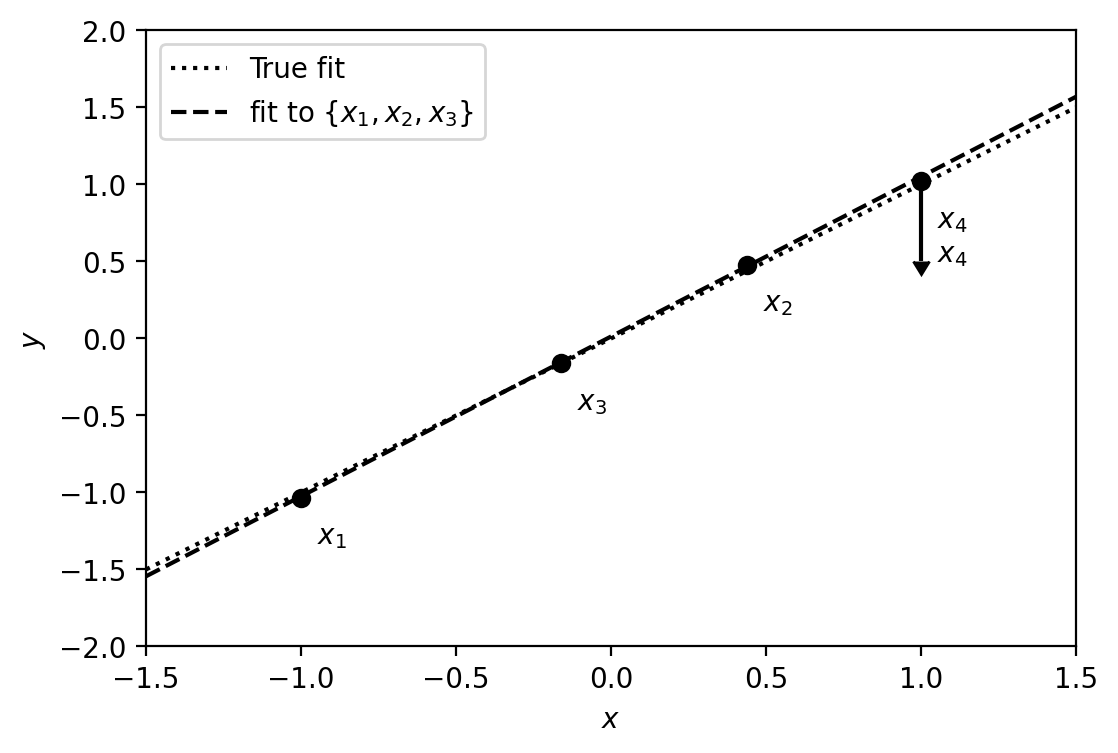

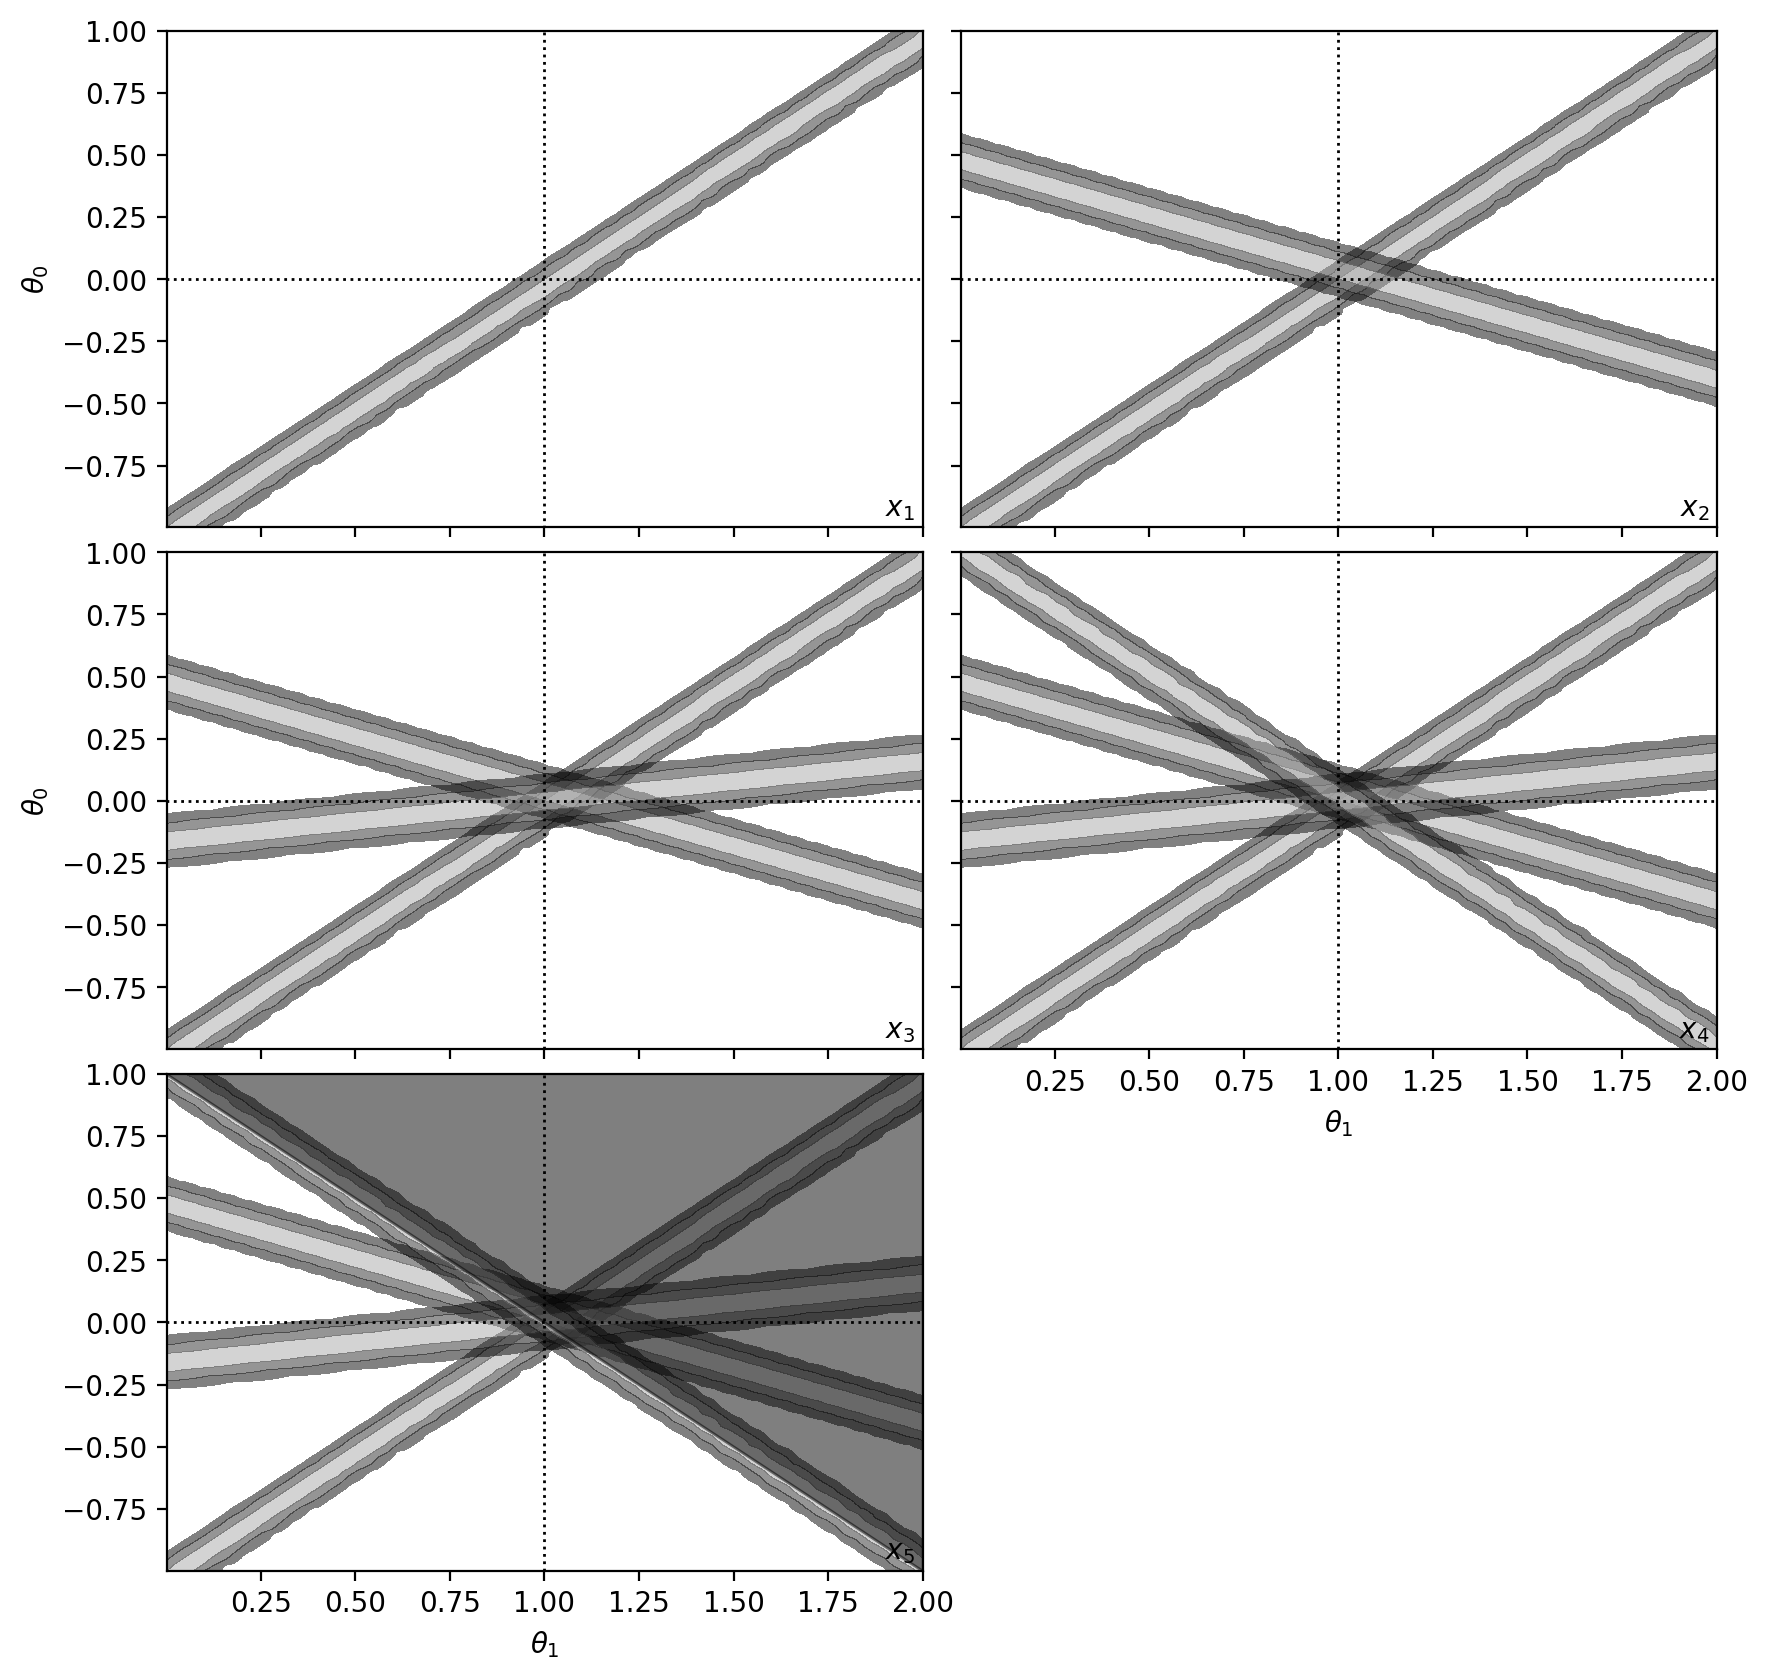

In [5]:
# Ivezic, Figure 8.1, modified by SRT and GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.plotting.mcmc import convert_to_stdev

#------------------------------------------------------------
# Set up the data and errors
np.random.seed(13)
a = 1
b = 0

x = np.array([-1, 0.44, -0.16, 1.0])
y = a * x + b
dy = np.array([0.05, 0.05, 0.05, 0.05])

y = np.random.normal(y, dy)

# add a fourth point which is a lower bound
x5 = 1.0
y5 = a * x5 + b + 0.0 

#------------------------------------------------------------
# Compute the likelihoods for each point
a_range = np.linspace(0, 2, 80)
b_range = np.linspace(-1, 1, 80)
logL = -((a_range[:, None, None] * x + 
          b_range[None, :, None] - y) / dy) ** 2
sigma = [convert_to_stdev(logL[:, :, i]) for i in range(4)]

# compute best-fit from first three points
logL_together = logL.sum(-1)
i, j = np.where(logL_together == np.max(logL_together))

amax = a_range[i[0]]
bmax = b_range[j[0]]

#------------------------------------------------------------
# Plot the first figure: the points and errorbars
fig1 = plt.figure(figsize=(6, 4))
ax1 = fig1.add_subplot(111)

# Draw the true and best-fit lines
xfit = np.array([-1.5, 1.5])
ax1.plot(xfit, a * xfit + b, ':k', label='True fit')
ax1.plot(xfit, amax * xfit + bmax, '--k', 
         label='fit to $\{x_1, x_2, x_3\}$')

ax1.legend(loc=2)

ax1.errorbar(x, y, dy, fmt='ok')
ax1.errorbar([x5], [y5], [[0.5], [0]], 
             fmt='_k', uplims=True)

for i in range(4):
    ax1.text(x[i] + 0.05, y[i] - 0.3, 
             "$x_{%i}$" % (i + 1))
ax1.text(x5 + 0.05, y5 - 0.5, "$x_4$")

ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-2, 2)

#------------------------------------------------------------
# Plot the second figure: likelihoods for each point
fig2 = plt.figure(figsize=(10, 10))
fig2.subplots_adjust(hspace=0.05, wspace=0.05)

# plot likelihood contours
for i in range(5):
    ax = fig2.add_subplot(321 + i)
    for j in range(min(i + 1, 4)):
        ax.contourf(a_range, b_range, sigma[j].T,
                    levels=(0, 0.683, 0.955, 0.997),
                    cmap=plt.cm.binary, alpha=0.5)

# plot the excluded area from the fourth point
axpb = a_range[:, None] * x5 + b_range[None, :]
mask = y5 < axpb
fig2.axes[4].fill_between(a_range, y5 - x5 * a_range, 
                          2, color='k', alpha=0.5)

# Label and adjust axes
for i in range(5):
    ax = fig2.axes[i]

    ax.text(1.98, -0.98, "$x_{%i}$" % (i + 1), 
            ha='right', va='bottom')

    ax.plot([0, 2], [0, 0], ':k', lw=1)
    ax.plot([1, 1], [-1, 1], ':k', lw=1)

    ax.set_xlim(0.001, 2)
    ax.set_ylim(-0.999, 1)

    if i in (1, 3):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 1, 2):
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i in (0, 2):
        ax.set_ylabel(r'$\theta_0$')
    if i in (3, 4):
        ax.set_xlabel(r'$\theta_1$')

plt.show()

- Now look at the top right panel. The addition of another data point is sufficient to fully constrain the properties of a linear relationship, shown by the intersection of the $(\theta_0,\theta_1)$ lines from each point.
- More data points yield more constraints, and the best fit solution is the intersection of all lines in model parameter space (as shown in the next 3 panels).

**NOTE:** The errors are really small so that the constraints are just lines in parameter space. The 4th $x$ value is shown as a point estimate and a limit, so that you can see that the excluded region from the limit just follows the line that would result had it been a detection.

## 2-D Linear Regression <a class="anchor" id="two"></a>

Let's start with the simplest case: a linear model with independent variable, $x$, and dependent variable, $y$:

$$y_i = \theta_0 + \theta_1 x_i + \epsilon_i,$$

where $\theta_0$ and $\theta_1$ are the coefficients of the model that we are trying to estimate, and $\epsilon_i$ is an additive noise term with $\epsilon_i = \mathscr{N}(0,\sigma_i)$. 

As we've seen many times, the full data likelihood is the product of each individual event likelihood:

$$p(\{y_i\}|\{x_i\},{\theta}, I) \propto \prod_{i=1}^N \exp \left(\frac{-(y_i- (\theta_0 + \theta_1x_{i}))^2}{  2\sigma_i^2}\right).$$

Assuming a flat/uninformative prior, the log of the posterior probability is then

$$\ln(p({\theta}|\{x_i, y_i\},I)) \propto \ln \mathcal(L)  \propto \sum_{i=1}^N \left(\frac{-(y_i- (\theta_0 + \theta_1x_{i}))^2}{  2\sigma_i^2}\right).$$

***We want to find the values of $\theta$ that maximize this expression, which is the same as minimizing the least squares.*** 

### Homoscedastic uncertainty scenario

With uncertainties that are the same for all points, this minimization yields

$$\theta_1 = \frac{\sum_i^N x_i y_i - \bar{x}\bar{y}}{\sum_i^N(x_i-\overline{x})^2},$$

and

$$\theta_0 = \overline{y} - \theta_1\overline{x},$$

where $\overline{x}$ and $\overline{y}$ are the mean values.

The estimate of the variance and the standard errors of the estimated parameters are

$$\sigma^2 = \sum_{i=1}^N (y_i - \theta_0 + \theta_1 x_i)^2,$$

$$\sigma_{\theta_1}^2 = \sigma^2\frac{1}{\sum_i^N(x_i-\overline{x})^2},$$

$$\sigma_{\theta_0}^2 = \sigma^2\left(\frac{1}{N} + \frac{\overline{x}^2}{\sum_i^N(x_i-\overline{x})^2}\right).$$

### Heteroscedastic uncertainty scenario

If the errors are instead different for each point, it is better to think of the problem in matrix notation:

$$Y = M \theta$$

where $Y$ is an $N$-dimensional vector of values ${y_i}$,

$$Y = \left[
    \begin{array}{c}
    y_0\\
    \vdots\\
    y_{N-1}
    \end{array}
    \right].
$$

For the straight line model, $\theta$ is simply a two-dimensional vector of regression coefficients,

$$
\theta = \left[
            \begin{array}{c}
            \theta_0\\
            \theta_1
            \end{array}
          \right],
$$

and **$M$ is a called the design matrix**

$$
M = \left[
        \begin{array}{cc}
        1 & x_0\\
        \vdots & \vdots\\
        1 & x_{N-1}
        \end{array}
    \right],
$$

where the constant in the first column of $M$ captures the zeropoint (i.e. the constant $y$-intercept) in the regression.

The log-likelihood can then be written as

$$ \ln\mathcal(L) = -\frac{1}{2}(Y-M\theta)^T C^{-1} (Y-M\theta) - \frac{1}{2}\ln[\mathrm{det}(C)]$$

where we encapsulate uncertainties in the ($N\times N$) covariance matrix

$$C=\left[
        \begin{array}{cccc}
        \sigma_{0}^2 & 0 & \cdots & 0 \\
        \vdots & \vdots & \cdots & \vdots \\
        0 & 0 & \cdots & \sigma_{N-1}^2 \\
        \end{array}
    \right].
$$

and the maximum likelihood solution for the regression can be analytically solved and expressed as

$$\theta = (M^T C^{-1} M)^{-1} (M^T C^{-1} Y),$$

which minimizes the sum of squares, and gives uncertainties on $\theta$ of 

$$\Sigma_\theta = \left[
                    \begin{array}{cc}
                    \sigma_{\theta_0}^2 & \sigma_{\theta_0\theta_1} \\
                    \sigma_{\theta_0\theta_1} & \sigma_{\theta_1}^2
                    \end{array}
                  \right]
                    = [M^T C^{-1} M]^{-1}.
$$

With `numpy` it is straightforward to write the matrices as multi-dimensional arrays, and do the linear algebra (provided the matrices are invertible), then calculate the regression coefficients.

Let's start with some noisy data and the known solution.

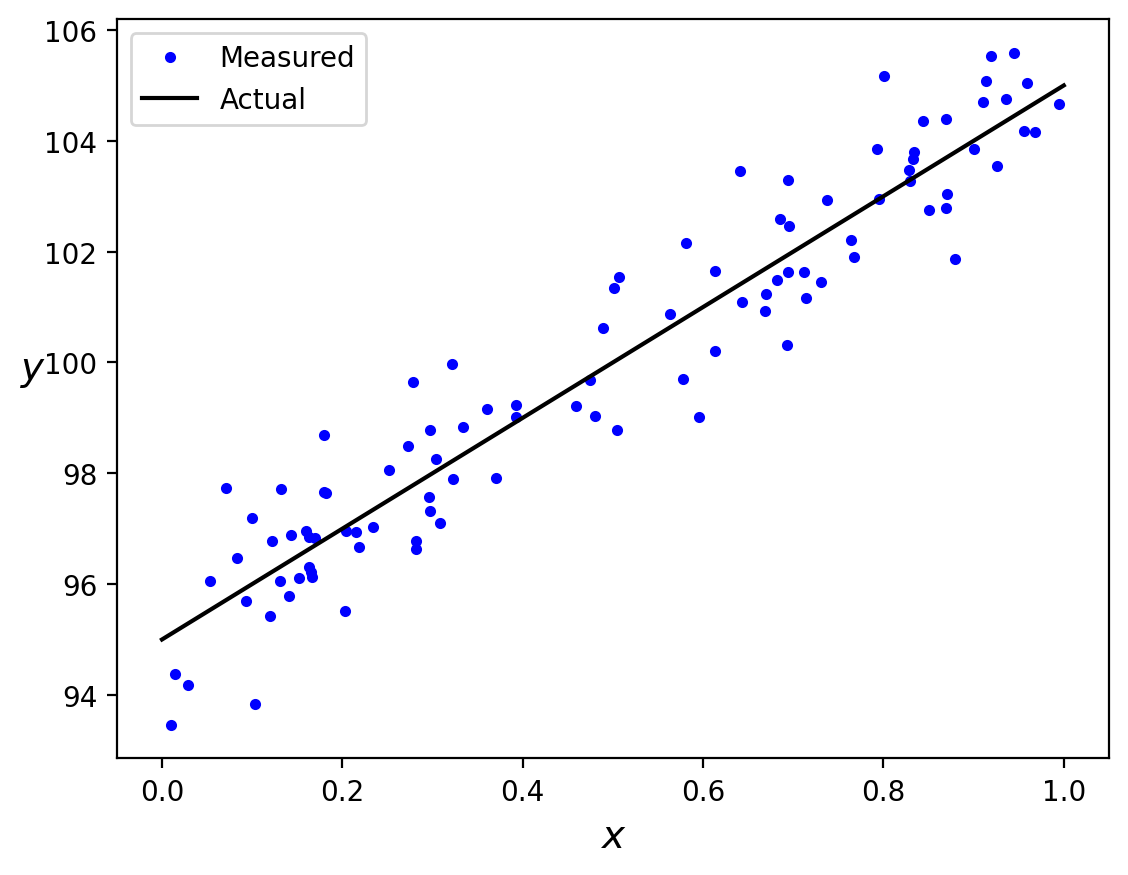

In [6]:
theta0 = 95 # Known value of b (theta0)
theta1 = 10 # Known value of m (theta1)
noise_std = 1.0 
noise = np.random.randn(100, 1) * noise_std
dy = noise

X = np.random.rand(100, 1)
y = theta0 + theta1 * X + dy

X_grid = np.linspace(0,1,11)
y_true = theta0 + theta1*X_grid

plt.plot(X, y, "b.", label='Measured')
plt.plot(X_grid, y_true, "k-", label='Actual')
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.legend()
plt.show()

Now solve for the $\theta$ values. First using matrix math as shown below.

In [7]:
# diagonal noise matrix
C = np.identity(len(X[:,0])) * noise_std**2

# design matrix
M = np.column_stack((np.ones(len(X[:,0])), X[:,0]))

# Sigma^-1 = M^T * C^-1 * M
A = np.dot(np.dot(M.T, np.linalg.pinv(C)), M)

# M^T * C^-1 * y
B = np.dot(np.dot(M.T, np.linalg.pinv(C)), y)

# theta = Sigma * M^T * C^-1 * y
theta = np.dot(np.linalg.pinv(A),B)
print(theta)

[[94.98203304]
 [10.08898825]]


Use the results to make predictions and compare to the known answer.

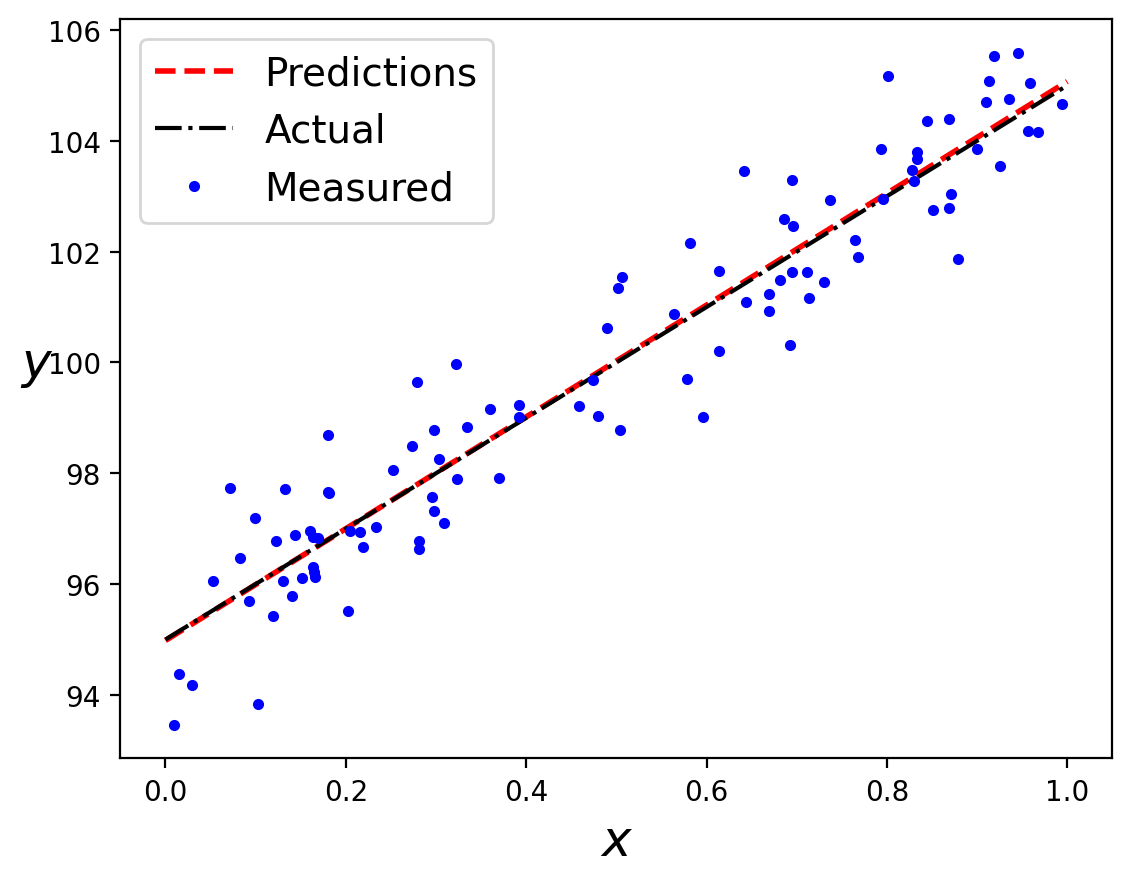

In [9]:
X_new = np.array([[0], [1]]) #like X_grid, but just with the endpoints
y_pred = theta[0] + theta[1]*X_new  # Complete 

plt.plot(X_new, y_pred, "r--", linewidth=2, label="Predictions")
plt.plot(X_grid, y_true, "k-.", label="Actual") # Comment this out to see that it agrees with the above
plt.plot(X, y, "b.", label='Measured')
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.show()

#N.B. you could also do this as 
#y_pred = np.dot(MM,theta)
#if MM were defined appropriately
#MM = np.column_stack((np.ones(len(X_grid)),X_grid))
#y_pred = np.dot(MM,theta)
#plt.plot(MM[:,1], y_pred, "r--", linewidth=2, label="Predictions")

Much easier with [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) from `Scikit-Learn`.

In [11]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y, sample_weight=1.0)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)
y_pred2 = lin_reg.predict(X_new)

[94.98203304] [[10.08898825]]


Now compare `y_pred` to `y_pred2`.

In [12]:
print(y_pred)
print(y_pred2)

[[ 94.98203304]
 [105.07102129]]
[[ 94.98203304]
 [105.07102129]]


So, what we did was to replace
```
C = np.identity(len(X))*(dy*dy)
M = np.column_stack((np.ones(len(X)),X))
A = np.dot(np.dot(M.transpose(),np.linalg.pinv(C)),M)
B = np.dot(np.dot(M.transpose(),np.linalg.pinv(C)),y)
theta = np.dot(np.linalg.pinv(A),B)

y_pred = np.dot(M_new,theta) # using design matrix at new x locations
```

with
```
LRmodel = LinearRegression()
LRmodel.fit(X, y, sample_weight=noise_std)
y_pred = LRmodel.predict(X_new)
```

### A Word of Caution

[Anscombe's Quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) is a demonstration of why you should always visualize your data and not just blindly use the parameters of some black-box fitting algorithm.

![Anscombe's Quartet](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Anscombe%27s_quartet_3.svg/1000px-Anscombe%27s_quartet_3.svg.png)

Each of these data sets has $11$ points and basic statistical properties that are identical. For example, they all have the same best fit when assuming a linear model.

## Multivariate linear regression <a class="anchor" id="three"></a>

In the above cases, we were doing 2-D linear regression with a univariate $X$.  If $X$ is instead multivariate, then we fit a hyperplane rather than a straight line

$$y_i =\theta_0 + \theta_1x_{i1} + \theta_2x_{i2} + \cdots +\theta_kx_{ik} + \epsilon_i.$$
 
The design matrix, $M$, is now 

$$M = \left(
        \begin{array}{ccccccc}
        1 & x_{01} & x_{02} & . & x_{0k}\\
        1 & x_{11} & x_{12} & . & x_{1k}\\
        . & . & . & .  & . \\
        1 & x_{N1} & x_{N2} & . & x_{Nk}\\
        \end{array}
      \right)
$$

but the whole formalism is exactly the same as before.



In [14]:
from astroML.linear_model import LinearRegression

Xtest = np.random.random((100,2)) # 100 points in 2D
dytest = np.random.random(100) # heteroscedastic errors
ytest = np.random.normal(Xtest[:,0] + Xtest[:,1], dytest) # y = 0 + 1*x1 + 1*x2

model = LinearRegression()
model.fit(Xtest, ytest, dytest)

print(model.coef_)
#y_pred = model.predict(X)

[-0.04179165  1.01898675  1.05452797]


Note that Scikit-Learn's [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) routine does not explicitly account for heteroscedastic error. This is unfortunate, but this generalization is implemented in [astroML.linear_model.LinearRegression](https://www.astroml.org/modules/generated/astroML.linear_model.LinearRegression.html).

## Polynomial Regression <a class="anchor" id="four"></a>

We introduced regression with examples of straight-line fitting, but we can think of it more generically in terms of **[polynomical regression](https://en.wikipedia.org/wiki/Polynomial_regression)** with $y=f(x|\theta)$ and

$$y_i =\theta_0 + \theta_1 x_{i} + \theta_2 x_{i}^2 + \theta_3 x_{i}^3 + \cdots.$$   

For example, maybe $y$ depends on the area or volume of an object, but you have mesured the length. More generally, this is like fitting a model that is a Taylor expansion of the exact $f(x)$ to determine amplitudes of the different polynomial terms.

For polynomical regression, the design matrix $M$ is now
 
$$
M = \left(
        \begin{array}{cccccc}
        1 & x_{0} & x_{0}^2 & x_{0}^3\\
        1 & x_{1} & x_{1}^2 & x_{1}^3\\
        . & . & . & . \\
        1 & x_{N} & x_{N}^2 & x_{N}^3\\
        \end{array}
    \right).
$$

**NOTE:** Be careful with terminology!! ***This is still Linear Regression since the model only depends linearly on the parameters.*** The "linear" in linear regression corresponds to these parameters, not the independent variable $x$.

As with linear regression, we'll use `PolynomialRegression` from `AstroML`.

In [11]:
# Typical call
from astroML.linear_model import PolynomialRegression

Xtest = np.random.random((100,1))
ytest = 2.5*Xtest[:,0]**2 + 5.0*Xtest[:,0]**3

degree = 3
model = PolynomialRegression(degree) # fit 3rd degree polynomial
model.fit(Xtest, ytest)

y_pred = model.predict(Xtest)
n_constraints = degree + 1

print(model.coef_)

[ 3.03074334e-15 -5.32907052e-15  2.50000000e+00  5.00000000e+00]


## Basis function regression <a class="anchor" id="five"></a>

If we consider a function in terms of a sum over bases (this can be polynomials, Gaussians, sines) then we can solve for the linear amplitude coefficients using regression. ***So regression with arbitrary basis terms that may be non-linear in $x$ is still linear regression, since the model is linear in the regression parameters.*** 

Above we have used polynomials, but we could substitute $x_{0}^2$ etc for Gaussians (where we fix $\sigma$ and $\mu$ and fit for the amplitude) as long as the attribute we are fitting for is linear. So if straight-line regression is just a special case of polynomial regression, then polynomial regression is just a special case of basis function regression. All of these are linear regression techniques.

In [12]:
#Basis function regression looks like this
from astroML.linear_model import BasisFunctionRegression

# data
Xtest = np.random.random((100,1))

ytest = np.random.normal(Xtest[:,0], dytest)

# mean positions of the 10 Gaussians in the model
X_gridtest = np.linspace(0,1,10)[:, None]
# widths of these Gaussians
sigma_test = 0.1

model = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=sigma_test)
model.fit(Xtest, ytest, dytest)

y_pred = model.predict(Xtest)
print(model.coef_)

[-2.22858199  0.32814614  0.27991267  0.17260046  0.37760029  0.22468128
  0.38122294  0.2290141   0.5042547   0.03533774  0.75574282]


## Kernel Regression <a class="anchor" id="six"></a>

In the case of Gaussian Basis Regression, if you think about it, we were back to the old problem of making a histogram.  Specifically, our Gaussians were evenly spaced over the range of interest. If we instead placed Gaussians at the location of every data point, we get Gaussian Kernel Regression instead. Or just **[Kernel Regression](https://en.wikipedia.org/wiki/Kernel_regression)** more generally since we don't *have* to have a Gaussian kernel function. It is also called **Nadaraya-Watson regression**.

Given a kernel $K(x_i,x)$ (e.g., a Gaussian or top-hat) at each point we estimate the function value by

$$f(x|K) = \frac{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right) y_i}
{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right)},$$

which is a weighted sum of $y$ (weighted by distance) with

$$w_i(x) = \frac{ K\left( \frac{||x_i-x||}{h} \right)}
{\sum_{i=1}^N K\left( \frac{||x_i-x||}{h} \right)}.$$

This **locally weighted regression** technique drives the regressed value to the nearest neighbor (when we have few points) which helps with extrapolation issues. As we saw with KDE, defining the correct bandwidth of the kernel is more important than the shape of the kernel itself and is done through **cross-validation**.

Nadaraya-Watson is implemented in `AstroML` as follows (note that the y errors are irrelevant, at least in this implementation)

In [13]:
from astroML.linear_model import NadarayaWatson

Xtest = np.random.random((100,2))
ytest = Xtest[:,0] + Xtest[:,1]

model = NadarayaWatson(kernel='gaussian', h=0.05)
model.fit(Xtest,ytest)

y_pred = model.predict(Xtest)

## Over/Under-fitting <a class="anchor" id="seven"></a>

We already talked a little bit about overfitting, but let's dive down deeper now that we are trying to fit complicated models. We'll use a 1-D model with homoscedastic errors for the sake of illustration, but this discussion applies to more complicated data as well.

To be clear, our data consists of $X_{\rm train}$, $y_{\rm train}$, and $X_{\rm test}$ and we are trying to predict $y_{\rm test}$.  

Let's take an example where

$$0\le x_i \le 3$$

and

$$y_i = x_i \sin(x_i) + \epsilon_i,$$

where the noise, $\epsilon_i$ is given by $\mathscr{N}(0,0.1)$.

In the example below, we draw 20 evenly spaced points from this distribution and fit them with a straight line.

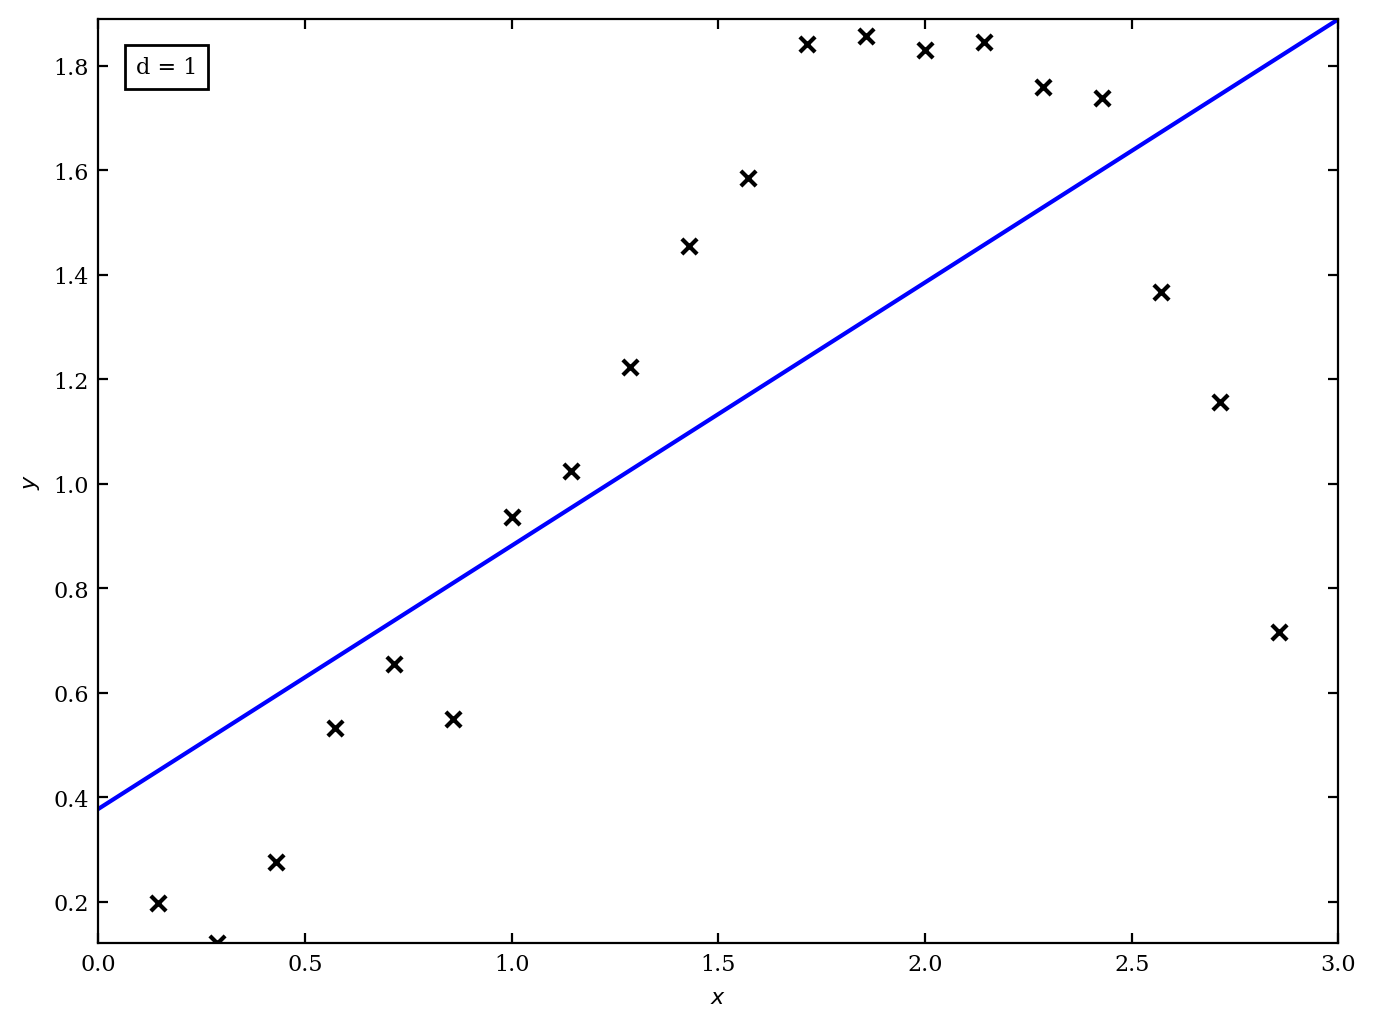

In [14]:
# Ivezic v2, Figure 8.12, plot made bigger by SRT and GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# First figure: plot points with a linear fit
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.scatter(x, y, marker='x', c='k', s=30)

p = np.polyfit(x, y, 1)
y_fit = np.polyval(p, x_fit)

ax.text(0.03, 0.96, "d = 1", transform=plt.gca().transAxes,
        ha='left', va='top',
        bbox=dict(ec='k', fc='w'))

ax.plot(x_fit, y_fit, '-b')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.show()

- This model **underfits** the data and is said to be "biased" (in the sense that the estimated model parameters deviate significantly from the true model parameters).  
- A straight line is a polynomial of order 1, so let's try polynomials of higher order.

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_40340/2206860561.py:51: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(x, y, d)


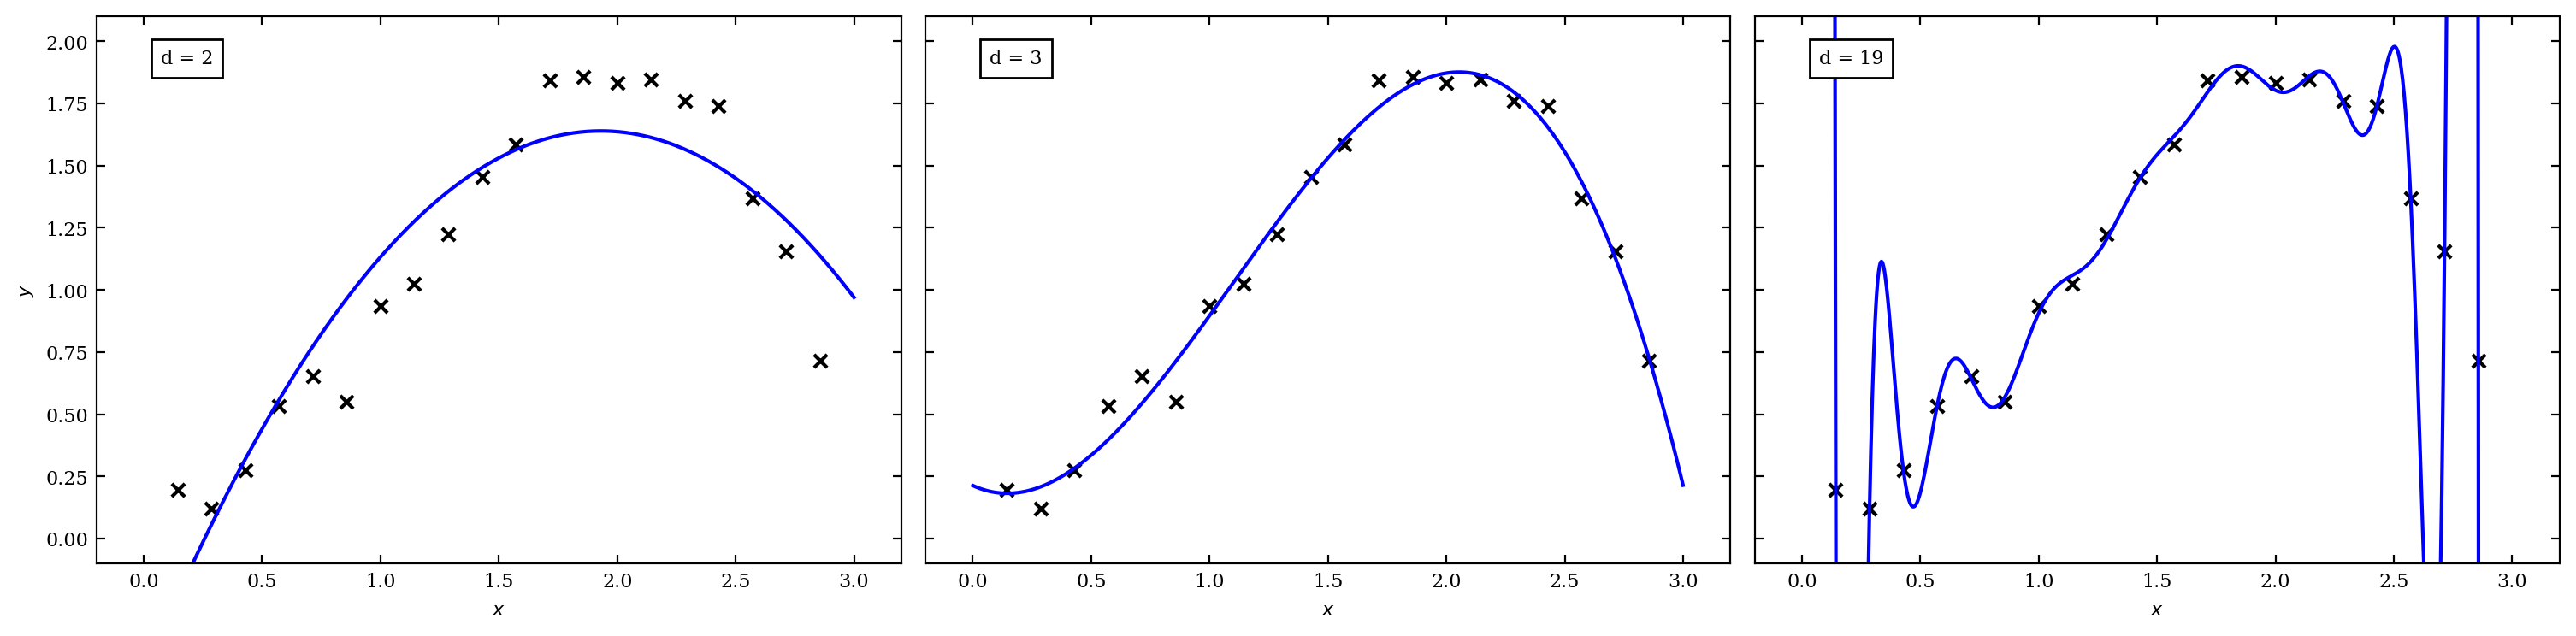

In [15]:
# Ivezic v2, Figure 8.13, panels made bigger by GTR and sizing altered by SRT
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import ticker
from matplotlib.patches import FancyArrow

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Second figure: plot fit for several orders of polynomial
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(wspace=0.03, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for i, d in enumerate([2, 3, 19]):  #Try 2nd, 3rd and 19th order
    ax = fig.add_subplot(131 + i)
    ax.scatter(x, y, marker='x', c='k', s=30)

    p = np.polyfit(x, y, d)
    y_fit = np.polyval(p, x_fit)

    ax.plot(x_fit, y_fit, '-b')
    ax.set_ylim(-0.1, 2.1)
    ax.set_xlim(-0.2, 3.2)
    if i in (1, 2):
        ax.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    ax.text(0.08, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w'))

plt.show()

Specifically, $2$, $3$, and all the way up to $19$. We see that $3$ is pretty good in that it seems to be relatively unbiased and also lacks the high variance of the `degree=19` fit (which is also unbiased, but overfit). ***So, how do we choose the "right" answer?***

## Cross-validation <a class="anchor" id="eight"></a>

Recap. In case you're still not sure about $k$-fold CV, the procedure is the followig:

- Split the data into $k+1$ subsets; the test set and $k$ CV sets. How you do this is up to you, but typically through random shufflings with equal numbers of points.
- $k$ models are trained, each time leaving out one of the CV sets in order to measure the CV error.
- The final training and CV error can be computed using the mean or median of the set of results. The median can be more reliable (but most application use the mean)

See the following GIF of $3$-fold CV from the [Wikipedia article](https://www.wikiwand.com/en/Cross-validation_(statistics)).


![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/KfoldCV.gif/1920px-KfoldCV.gif?1616979144969)

More regression coefficients improve the ability of the model to fit all the points (reduced **bias**), but at the expense of model complexity and **variance**. *Of course* we can fit a Nth-degree polynomial to N data points, but that would be foolish. We'll determine the best trade-off between bias and variance through [cross-validation](https://en.wikipedia.org/wiki/Cross-validation).

When we increase the complexity of a model, the data points fit the model more and more closely. However, this process does not necessarily result in a better fit to the data. Rather, if the degree is too high, then we are ***overfitting*** the data. The model has high variance, meaning that a small change in a training point can change the model dramatically.  

We can evaluate this using a **training set** ($50-70\%$ of sample), a **cross-validation set** ($15-25\%$) and a **test set** ($15-25\%$).

The training set is used the determine the model paramters, $\theta_j$.  The training data and cross-validation data then are both used to evaluate the training and cross-validation rms errors ($\epsilon_{\rm tr}$ and $\epsilon_{\rm CV}$; evaluated here for polynomial regression):

$$\epsilon_{\rm cv/tr} = \sqrt{\frac{1}{n}\sum_{i=1}^{N_{\rm cv/tr}}
  \left[y_i - \sum_{m=0}^d \theta_0^{(n)}x_i^m\right]^2}$$

> *Why do we need both a training set and a cross-validation set?* 
> - The **model parameters, $\theta_j$, are learned from the training set**,
> - But the **"hyperparameters" (in this case the model degree) are learned from the cross-validation set**. 

> *The test set then provides the best estimate of the error expected for a new set of unlabeled data.*

We show this graphically in the next figure (Ivezic, 8.14), where the **training and cross-validation rms errors are computed as a function of polynomial degree**, and also compared with the **model BIC**. 

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_40340/81325866.py:46: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(x, y, d[i])
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_40340/81325866.py:46: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(x, y, d[i])
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_40340/81325866.py:46: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(x, y, d[i])


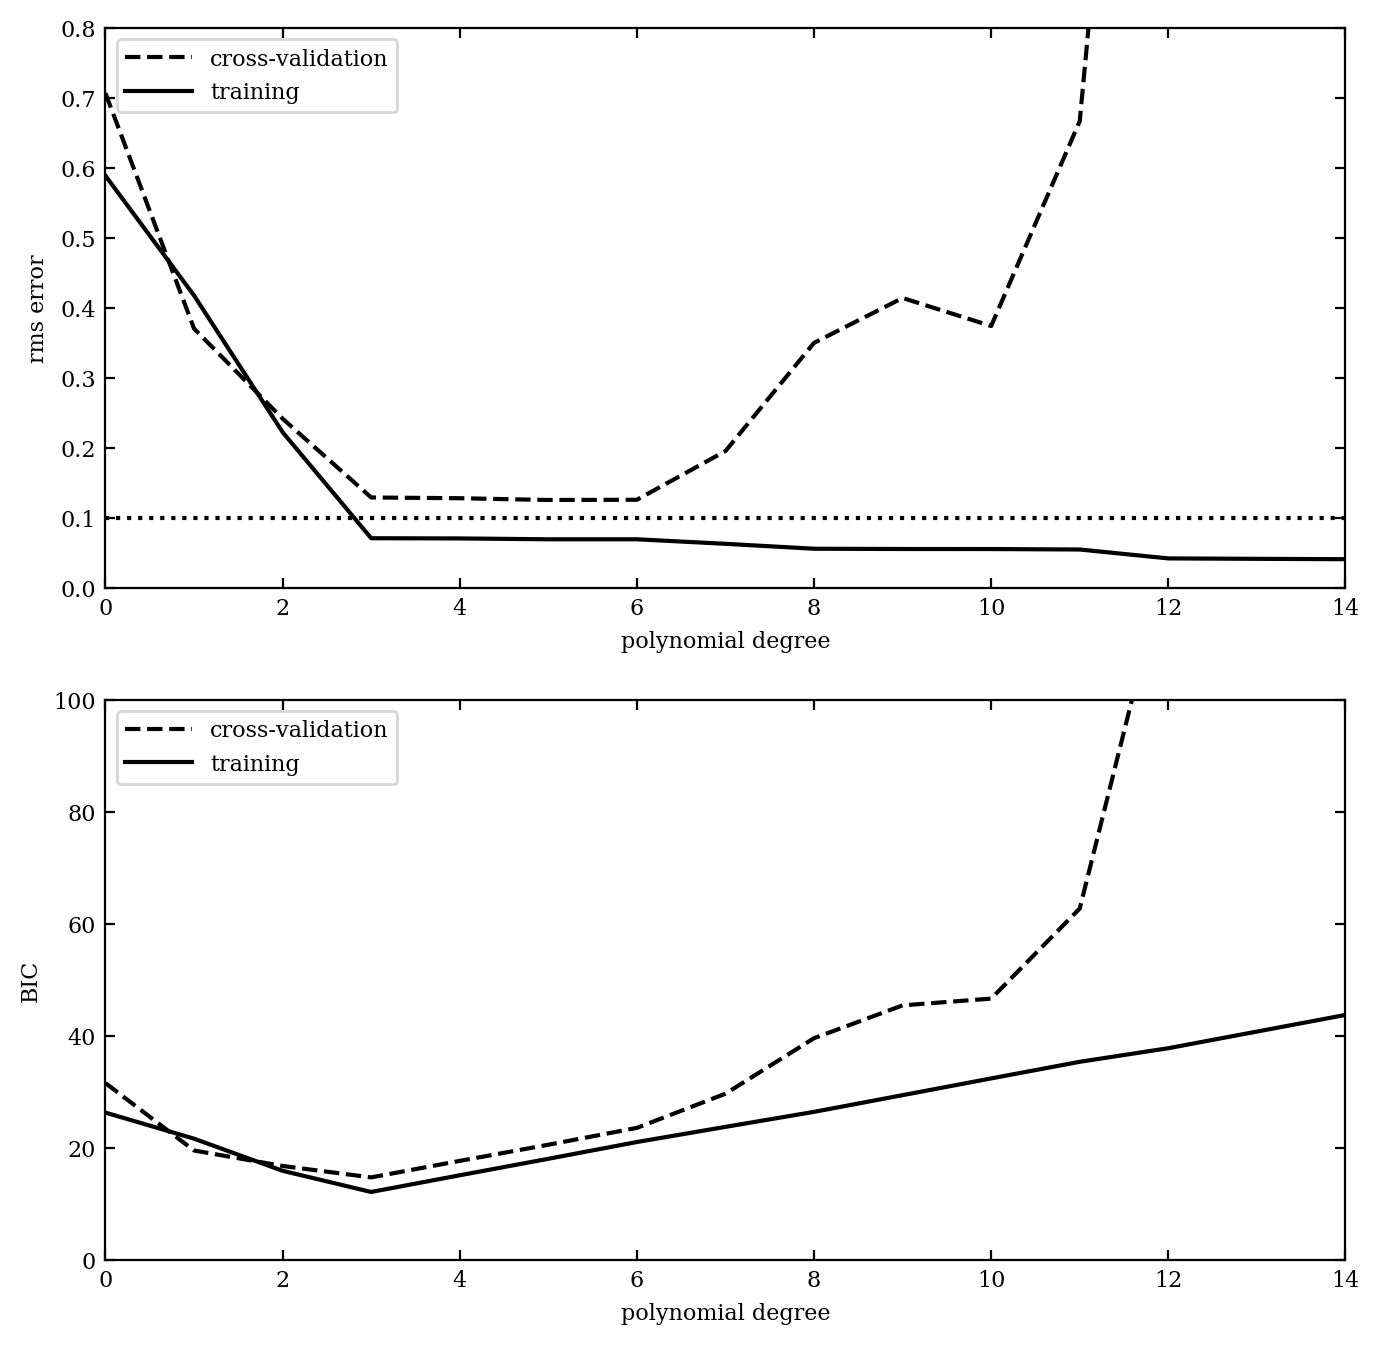

In [16]:
# Ivezic v2, Figure 8.14, panels made bigger by GTR
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Third figure: plot errors as a function of polynomial degree d
d = np.arange(0, 21)
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig = plt.figure(figsize=(8, 8))
for i in range(len(d)):
    p = np.polyfit(x, y, d[i])
    training_err[i] = np.sqrt(np.sum((np.polyval(p, x) - y) ** 2)
                              / len(y))
    crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv) ** 2)
                              / len(y_cv))

BIC_train = np.sqrt(len(y)) * training_err / dy + d * np.log(len(y))
BIC_crossval = np.sqrt(len(y)) * crossval_err / dy + d * np.log(len(y))

ax = fig.add_subplot(211)
ax.plot(d, crossval_err, '--k', label='cross-validation')
ax.plot(d, training_err, '-k', label='training')
ax.plot(d, 0.1 * np.ones(d.shape), ':k')

ax.set_xlim(0, 14)
ax.set_ylim(0, 0.8)

ax.set_xlabel('polynomial degree')
ax.set_ylabel('rms error')
ax.legend(loc=2)

ax = fig.add_subplot(212)
ax.plot(d, BIC_crossval, '--k', label='cross-validation')
ax.plot(d, BIC_train, '-k', label='training')

ax.set_xlim(0, 14)
ax.set_ylim(0, 100)

ax.legend(loc=2)
ax.set_xlabel('polynomial degree')
ax.set_ylabel('BIC')

plt.show()

- For low order, both the training and CV error are high. This is sign of a **high-bias model that is underfitting** the data.  
- For high order, the training error becomes small (by definition), but the CV error is large. This is the sign of a **high-variance model that is overfitting** the data. It is matching the subtle fluctuations in the training data that aren't really real, and this shows up in the CV analysis.
- The BICs give similar results.

Hopefully that helps you understand how to use cross validation to help you both **fit your model and decide on the optimal level of model complexity**, but maybe it doesn't help you apply it to your own data.  

We've already seen how to do this with **[GridSearchCV](https://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV)**, where for this case, we'd just be varying one parameter (even though `GridSearchCV` can vary many). That is, if the algorithm you're using support's the scikit-learn GridSearchCV infrastructure...

## Do we need more data? Learning Curves

Of course more data means a better fit... but a some point data are all the same!

We can use a tool called a **[learning curve](https://en.wikipedia.org/wiki/Learning_curve)** to determine if (for a given model) having more training data would help improve the model fitting. This is a different question than above-- rather than try to get a better model of the data, we're trying to improve the quality of our data set. 

The training and CV error are computed as a function of the number of training points. In general:
- ***The training error increases with $N_\mathrm{train}$.*** For a given model, it's easier to fit fewer data points.
- ***The CV error decreases wtih $N_\mathrm{train}$.*** For a given model, a greater number of training points reduces the chances of over-fitting, resulting in better performance of the model in the cross-validation stage.

Let's look at this for the same data and model as above.

/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_40340/2836703255.py:59: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(x[:N], y[:N], d)
/var/folders/zv/8t9z941x3q1gmp080mdw8k_h0000gn/T/ipykernel_40340/2836703255.py:59: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(x[:N], y[:N], d)


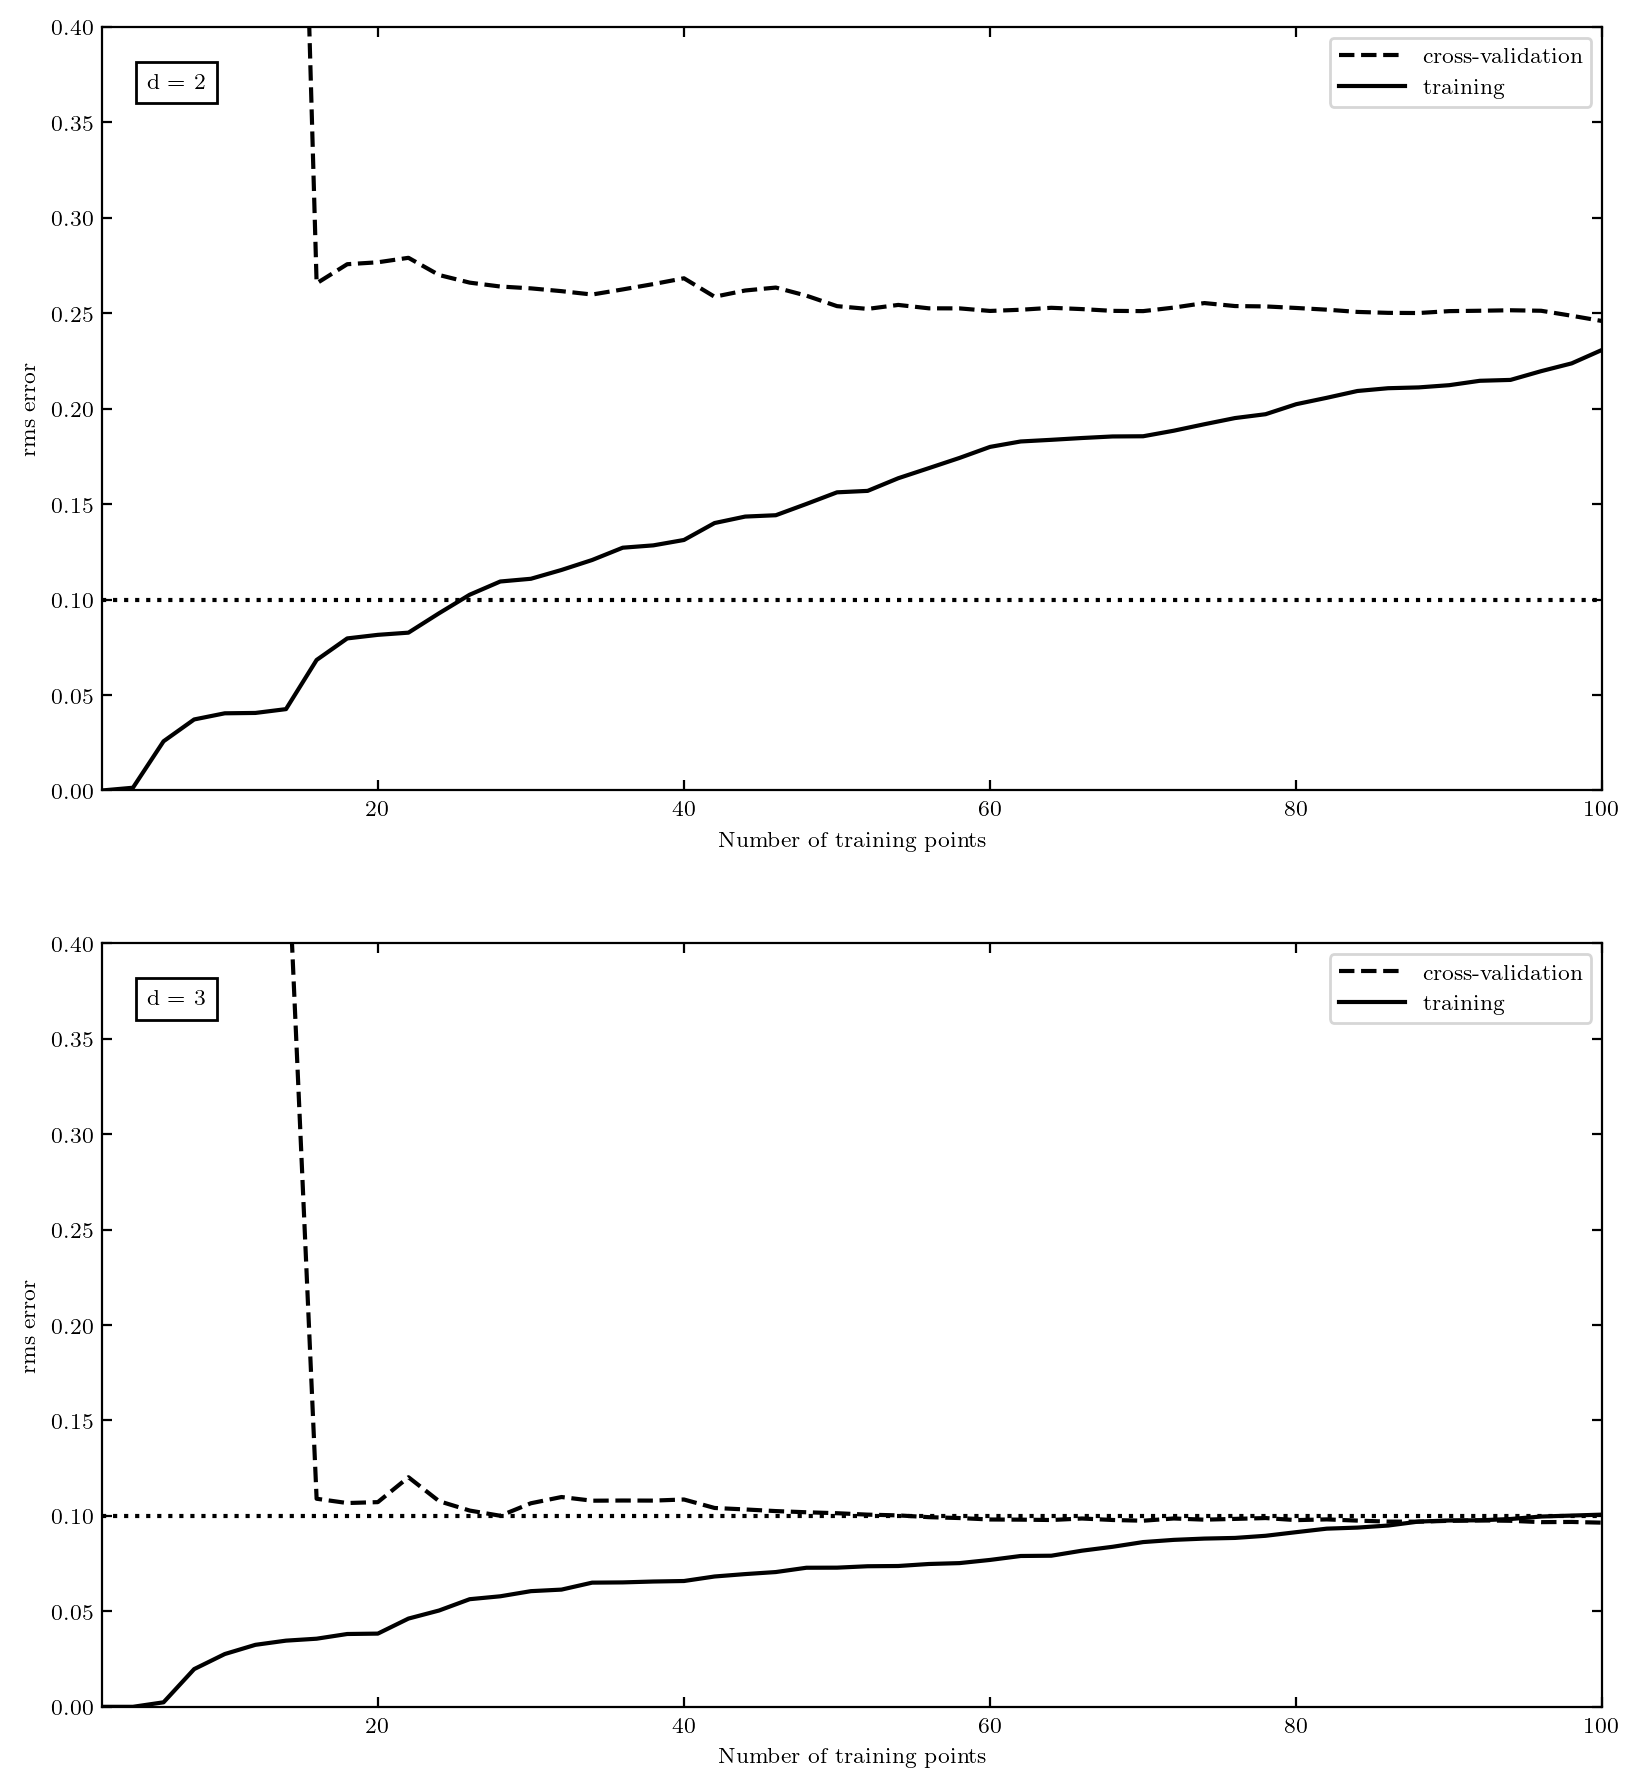

In [17]:
# Ivezic v2, Figure 8.15, panels made bigger by GTR and starting at 2 points.
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Define our functional form
def func(x, dy=0.1):
    return np.random.normal(np.sin(x) * x, dy)

#------------------------------------------------------------
# select the (noisy) data
np.random.seed(0)
x = np.linspace(0, 3, 22)[1:-1]
dy = 0.1
y = func(x, dy)

#------------------------------------------------------------
# Select the cross-validation points
np.random.seed(1)
x_cv = 3 * np.random.random(20)
y_cv = func(x_cv)

x_fit = np.linspace(0, 3, 1000)

#------------------------------------------------------------
# Fourth figure: plot errors as a function of training set size
np.random.seed(0)
x = 3 * np.random.random(100)
y = func(x)

np.random.seed(1)
x_cv = 3 * np.random.random(100)
y_cv = func(x_cv)

Nrange = np.arange(2, 101, 2)

fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.15, top=0.95)

for subplot, d in zip([211, 212], [2, 3]):
    ax = fig.add_subplot(subplot)
    training_err = np.zeros(Nrange.shape)
    crossval_err = np.zeros(Nrange.shape)

    for j, N in enumerate(Nrange):
        p = np.polyfit(x[:N], y[:N], d)
        training_err[j] = np.sqrt(np.sum((np.polyval(p, x[:N])
                                          - y[:N]) ** 2) / len(y))
        crossval_err[j] = np.sqrt(np.sum((np.polyval(p, x_cv)
                                          - y_cv) ** 2) / len(y_cv))

    ax.plot(Nrange, crossval_err, '--k', label='cross-validation')
    ax.plot(Nrange, training_err, '-k', label='training')
    ax.plot(Nrange, 0.1 * np.ones(Nrange.shape), ':k')
    ax.legend(loc=1)
    ax.text(0.03, 0.94, "d = %i" % d, transform=ax.transAxes,
            ha='left', va='top', bbox=dict(ec='k', fc='w'))

    ax.set_ylim(0, 0.4)

    ax.set_xlabel('Number of training points')
    ax.set_ylabel('rms error')

plt.show()

We can see two regimes:

1. ***The training and CV errors have converged.*** This indicates that the model is dominated by bias. Increasing the number of training points is futile. If the error is too high, you instead need a more complex model, not more training data.
2. ***The training error is smaller than the CV error.*** This indicates that the model is dominated by variance.  Increasing the number of training points may help to improve the model.

In both cases, for small numbers of training points, the difference between the training and CV errors indicates that more data well help.  

For the top plot, the convergence of the training and CV errors indicates that adding further data will not reduce the error as it is dominated by ***bias***. A more sophisticated model is needed. The training error starts at zero because we are predicting the training data perfectly, but the CV error is high, indicating that the training data aren't sufficiently representative.

Again, hopefully that helps you understand what learning curves tell you, but maybe it doesn't help you apply it to your own data.  So, let's see how sklearn does it using [sklearn.model_selection.learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve).  

We apply this to the [Boston Housing data](https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset). This is one of the most famous datasets in ML and contains attributes that can be used to predict the price of houses in Boston (number of rooms, geographic area, etc).

In [18]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.feature_names)

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


**Yes, machine learning has ethical issues**. I'm not covering this at all in my class but it's a very serious problem.  Some examples:

- This dates back to 1988, where an hospital had been using a computer program trained from data of previous admissions, and this program had denied nearly 60 candidates who were found to be either women or had non-European sounding names. [paper](https://read.dukeupress.edu/world-policy-journal/article-abstract/33/4/111/30942/Racist-in-the-MachineThe-Disturbing-Implications?redirectedFrom=fulltext)
- Companies have been hiring using ML trained on current employees (those people are good, we want people like them), which was found to reinforce racist hiring policies. ML makes the bias worse! [blog1](https://theoutline.com/post/1571/the-fight-against-racist-algorithms) [blog2](https://theoutline.com/post/1439/machine-learning-is-racist-because-the-internet-is-racist)
- Policing company that found that “disproportionately high levels of over-policing in low-income and minority communities” after being trained with historical crime data. [paper](https://brie.berkeley.edu/sites/default/files/brie_wp_2018-3.pdf)
- For hospitals, concerns that ML systems might not be trained in the public's interest but as income-generating machines for companies. [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5962261/)

Astrophysicists might not be working with patients' data but, for instance, we have [confirmation biases](https://arxiv.org/abs/2210.07078). Are we training a machine to find what we think we should find? Or are we truly discovering something new? 

Let's use the California housing dataset then...


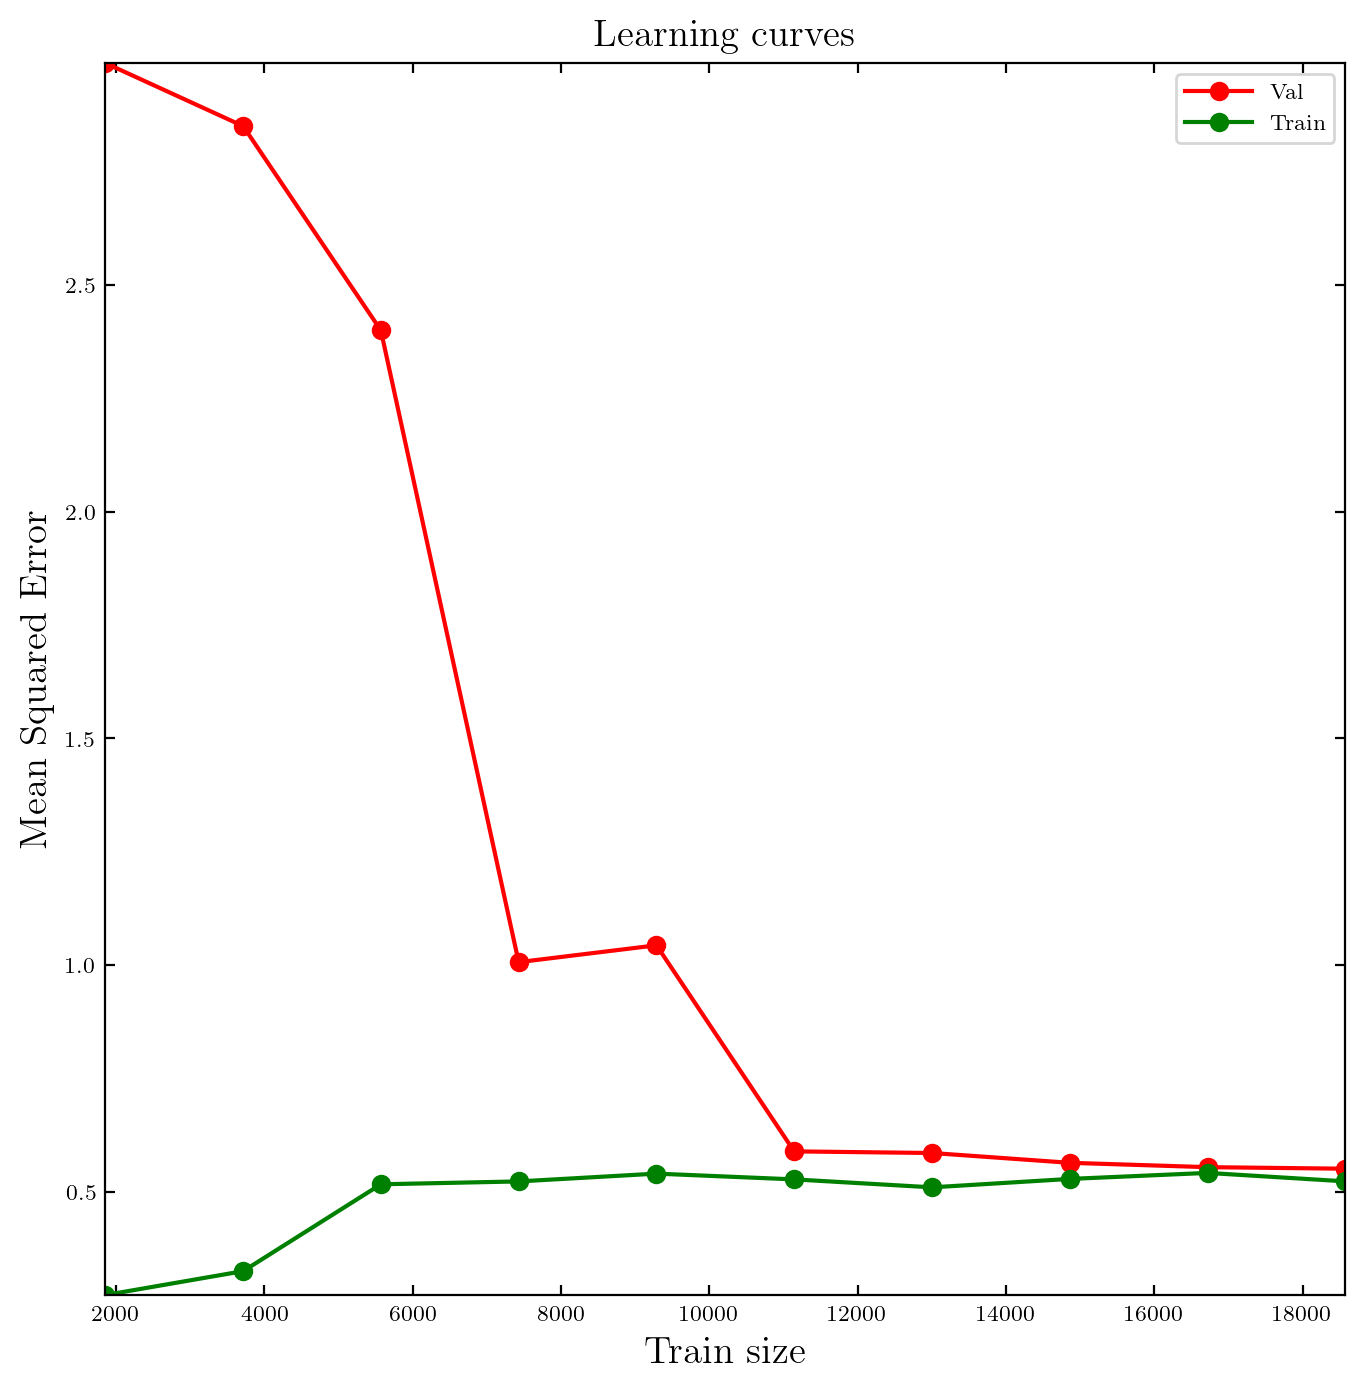

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

#boston = load_boston()
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

X = california.data
y = california.target

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

lin_reg = LinearRegression()
# Ten training sample sizes from 10% to 100%
train_sizes, train_scores_linreg, test_scores_linreg = \
    learning_curve(lin_reg, Xscaled, y, train_sizes=np.linspace(0.1, 1, 10), \
    scoring="neg_mean_squared_error", cv=10)

fig = plt.figure(figsize=(8, 8))

plt.plot(train_sizes, -test_scores_linreg.mean(1), 'o-', color="r", label="Val")
plt.plot(train_sizes, -train_scores_linreg.mean(1), 'o-', color="g", label="Train")
                   
plt.xlabel("Train size",fontsize=14)
plt.ylabel("Mean Squared Error",fontsize=14)
plt.title('Learning curves',fontsize=14)
plt.legend(loc="best")
#plt.ylim(0,200)

#plt.show()

So, it looks like we have enough data here.  This is important to know when we are deciding on the number of cross validations.  

Once you are happy with the size of your training set and your choice of model, and now just want to get the best model parameters using *all* of the data (not just whatever fraction is in your training set), then we can use **[cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)**.

"Each sample belongs to exactly one test set, and its prediction is computed with an estimator fitted on the corresponding training set."

Let's use this to predict the price of houses in Boston where each house gets to be part of one of the test sets by doing a $10$-fold cross validation. We will then plot the *prediction* versus the *actual* value of $y$, which should lie along the line $y=y_\mathrm{pred}$.

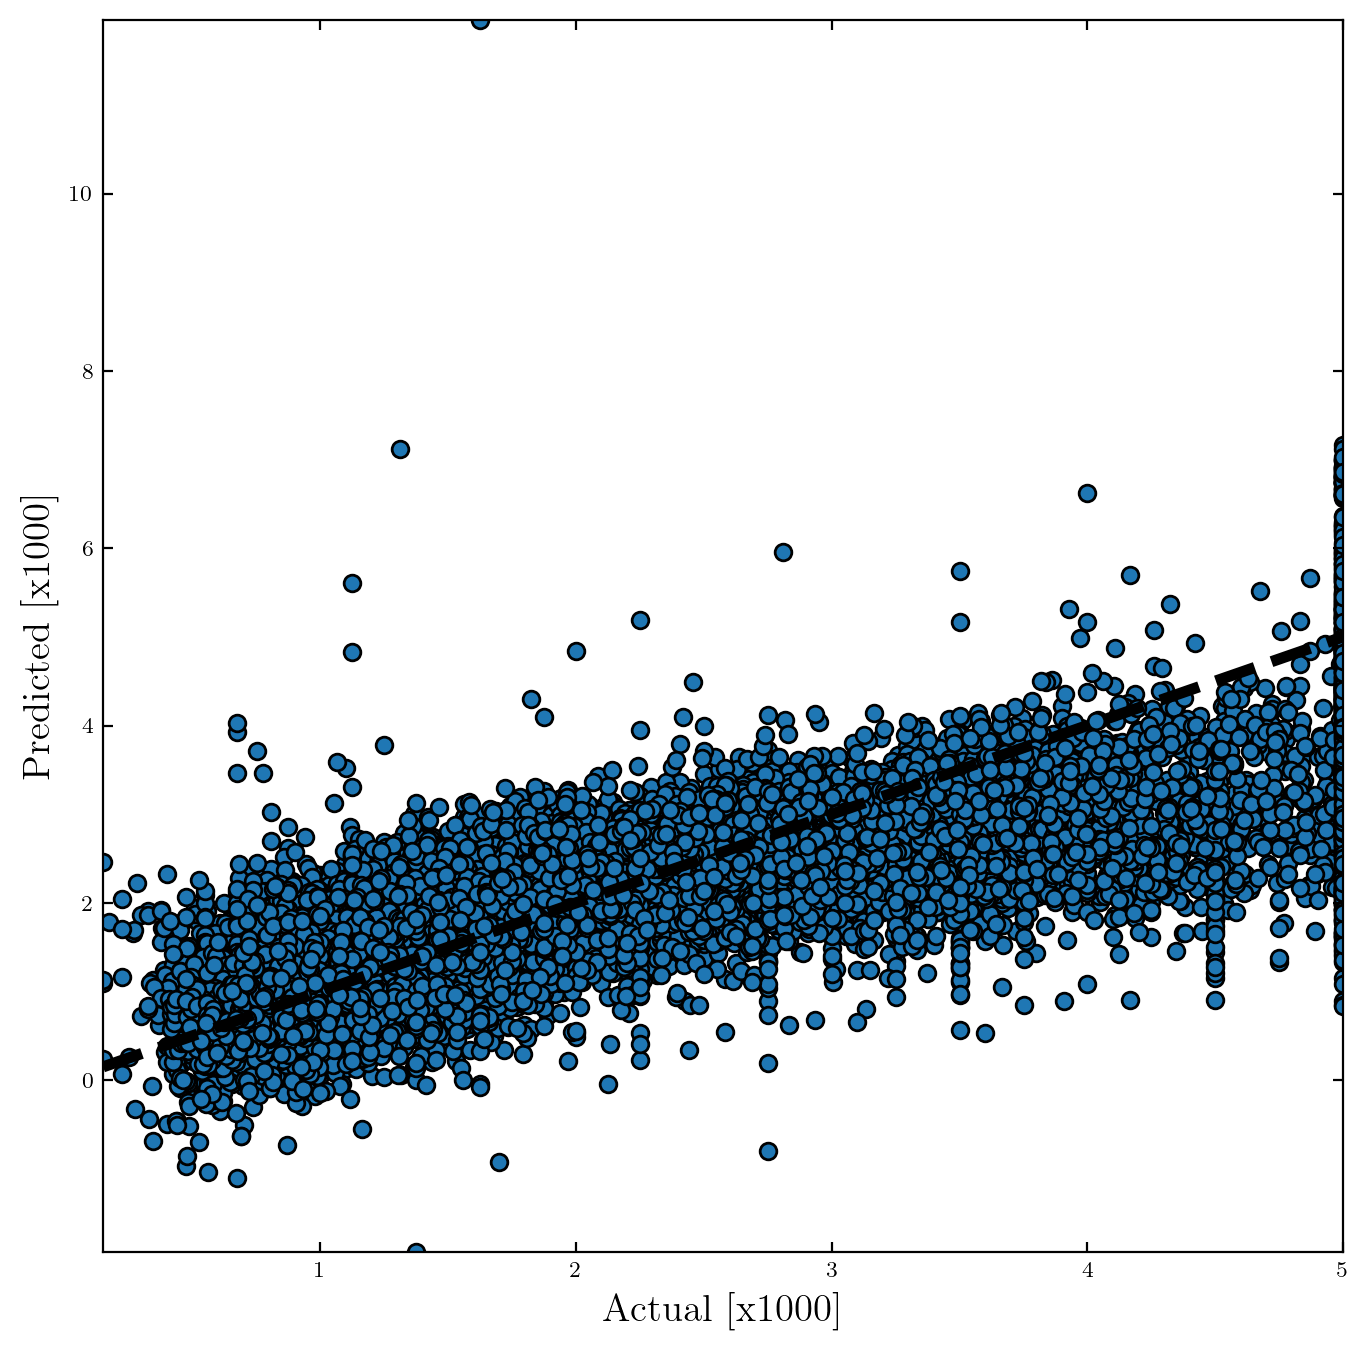

In [20]:
from sklearn.model_selection import cross_val_predict

scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)
linreg = LinearRegression()
linreg.fit(Xscaled, y)

# Do a 10-fold cross validation
# Then try a 3-fold cross validation
# Can you understand the difference?
ypred = cross_val_predict(linreg, Xscaled, y, cv=10)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y, ypred, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual [x1000]',fontsize=14)
ax.set_ylabel('Predicted [x1000]',fontsize=14)
plt.show()

## Time to get your hands dirty! Supernova distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a [Nobel prize](https://www.nobelprize.org/prizes/physics/2011/riess/facts/) plot by [Riess et al](https://iopscience.iop.org/article/10.1086/300499)

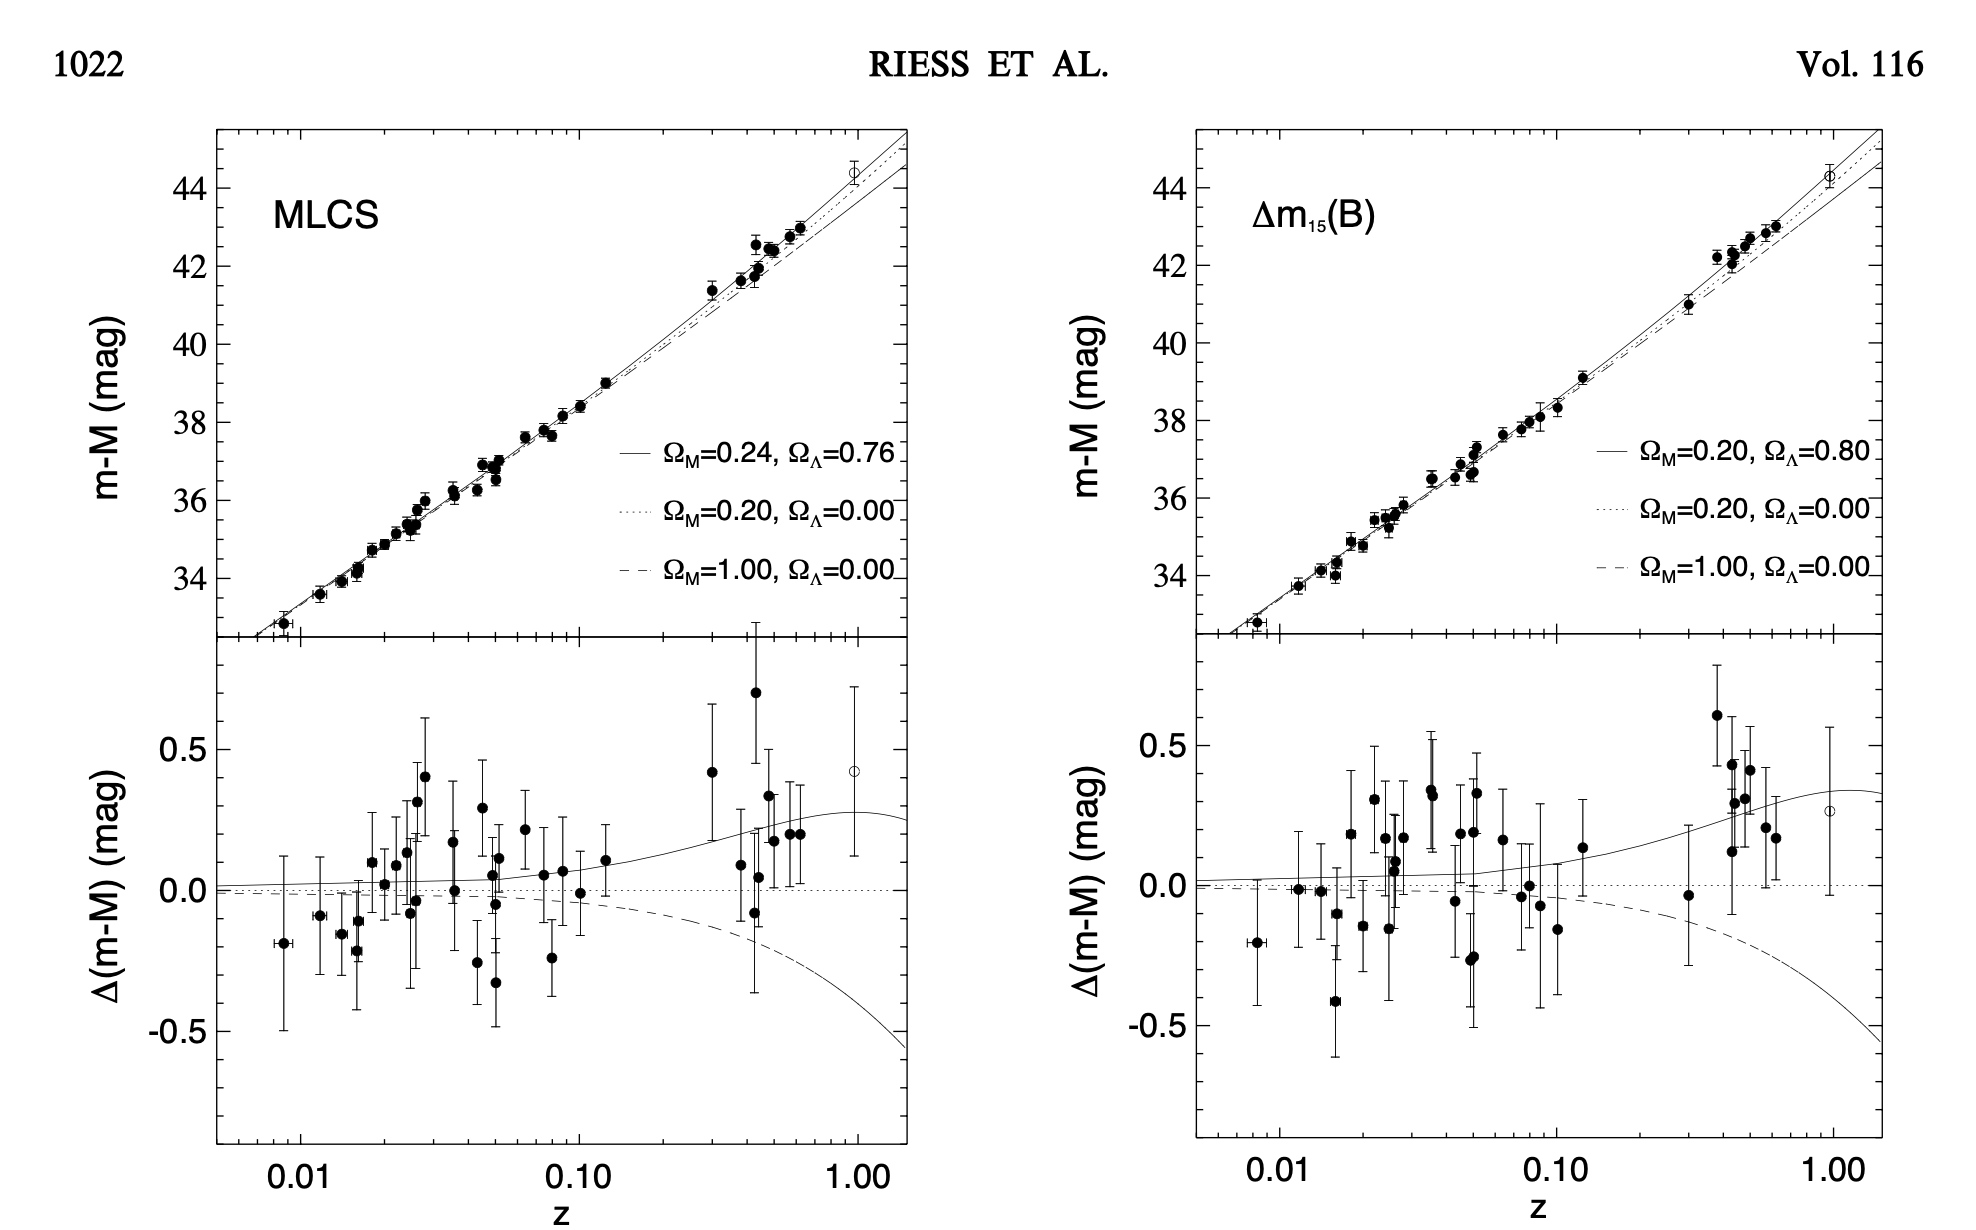

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

These are some (synthetic but realistic; see textbook) supernova data

(35.0, 50.0)

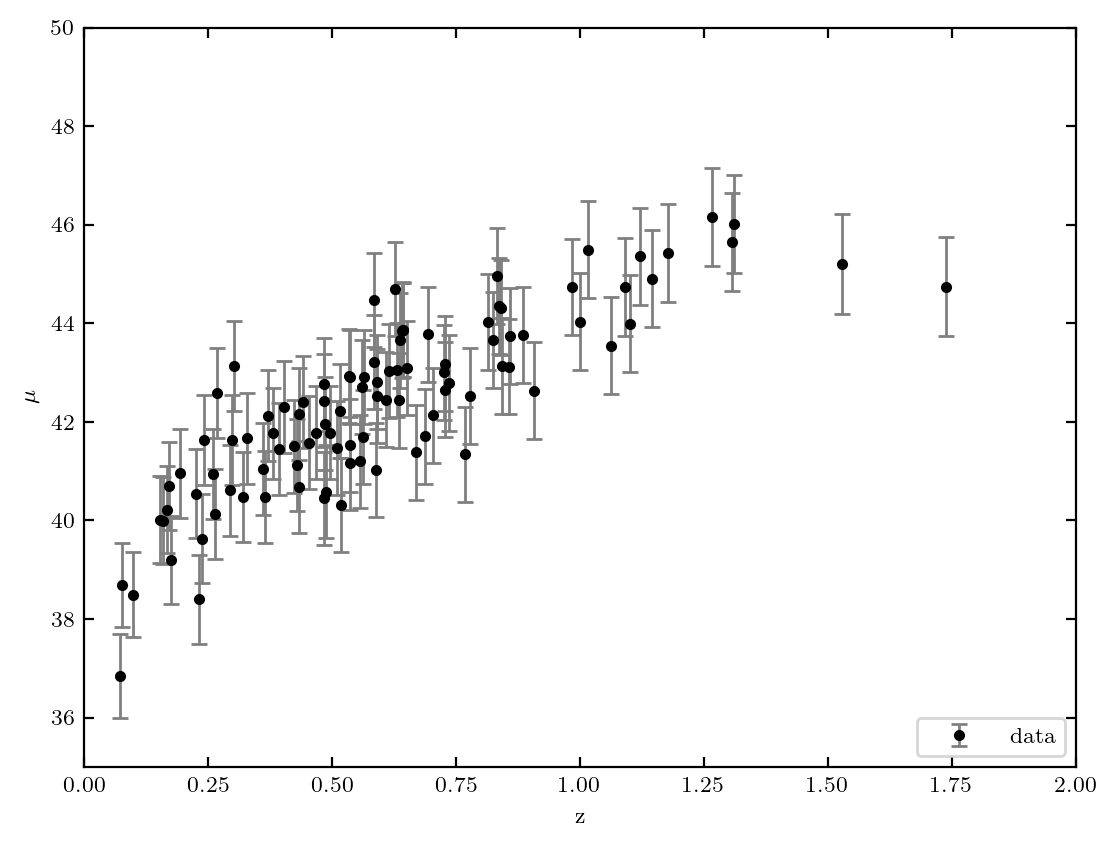

In [21]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

[My exploration](https://github.com/dgerosa/astrostatistics_bicocca_2025/blob/main/solutions/S15_supernovae1.ipynb)